# Example 4a: Dynamic nonequilibrium force field - Training of DeepCalib

Example code to train DeepCalib to determine the parameters of a Brownian particle in a dynamic nonequilibrium force field.

<strong>DeepCalib 1.0</strong><br/>
Enhanced force-field calibration via machine learning<br/>
version 1.0 - 27 April 2020<br/>
© Aykut Argun, Tobias Thalheim, Stefano Bo, Frank Cichos & Giovanni Volpe <br/>
[Soft Matter Lab](http://www.softmatterlab.org)

## 1. INIZIALIZATION

In [2]:
import DeepCalib

%matplotlib inline
from math import pi
from scipy.constants import Boltzmann as kB
from numpy import log10

## 2. DEFINE TRAJECTORY SIMULATION 
<a id="sec2"></a>

Here the function that simulates the motion of the Brownian particle in the force field under consideration is defined. Specifically, in this case, we consider a Brownian particle in a dynamic nonequilibrium force field, and the motion of the particle depends on three target parameters: the higher trap stiffness ky, the lower trap stiffness kx and the switching frequency f. This function is used to generate the pretrained network "Network_Example_4a.h5" that is going to be used in analyzing the experimental data in Examble 4b. 

Comments:
1. The function that simulates the trajectories must be called <strong>simulate_trajectory</strong>.
2. Lambda functions <strong>scale_inputs</strong>, <strong>rescale_inputs</strong>, <strong>scale_targets</strong>, and <strong>rescale_targets</strong> must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [13]:
### Physical parameters 
R = 1e-7                       # Radius of the Brownian particle [m]
eta = 0.001                    # Viscosity of the medium [kg m^-1 s^-1]
T = 300                        # Temperature [K]
k0 = 25                        # reference stiffness value 
f0 = 0.05                      # reference frequency value
gamma0 = 2* 6 * pi * eta * R  # Reference friction coefficient [kg s^-1]

### Simulation parameters
N = 1000                   # Number of samples of the trajectory
Dt = 1e-1                  # Timestep 
oversampling = 50          # Simulation oversampling
offset = 1000              # Number of equilibration points

### Define functions to scale and rescale inputs
scale_inputs = lambda x: x * 1e+6                    # Scales input trajectory to order 1
rescale_inputs = lambda scaled_x: scaled_x * 1e-6    # Rescales input trajectory to physical units


### Define function to scale and rescale targets
scale_targets = lambda kx, ky, f: [log10(kx / k0), 
                                   log10(ky / k0),
                                   log10( f / f0)]                              # Scales targets to order 1
rescale_targets = lambda scaled_kx, scaled_ky, scaled_f: [10**scaled_kx * k0,
                                                          10**scaled_ky * k0,
                                                          10**scaled_f  * f0]   # Inverse of targets_scaling

### Define the simulate_trajectory function

def simulate_trajectory(batch_size=32, 
                        T=T,
                        k0=k0,
                        f0=f0,
                        gamma0=gamma0,
                        N=N, 
                        Dt=Dt, 
                        oversampling=oversampling, 
                        offset=offset,
                        scale_inputs=scale_inputs, 
                        scale_targets=scale_targets):
    
    """Simulates a Brownian particle in a harmonic trap
    
    INPUTS:    
    
    batch_size   : size of the batch for the specific training step
    T            : absolute temperature of the medium
    k0           : reference (normalization) value of the stiffness coefficient
    f0           : reference (normalization) value of the frequency
    gamma0       : 
    N            : length of the output trajectory
    Dt           : time resolution of the output trajectory
    oversampling : the ratio of Dt and simulation timestep
    offset       : number of simulation step for initial equilibriation
    scale_inputs : function to scale inputs to values of order 1
    scale_targets: function to scale targets to values of order 1
    
    
    OUTPUTS:
    
    inputs       : inputs prepared in two scales (real and scaled values) that consists of 4 attributes (names, values, scalings, scaled_values)
    targets      : targets prepared in two scales (real and scaled values) that consists of 4 attributes (names, values, scalings, scaled_values)
                    

    """  

    import numpy as np
    from scipy.constants import Boltzmann as kB
    from math import pi
    from math import sqrt
    from numpy.random import randn as gauss
    from numpy.random import rand as uniform
   
    ### Randomize trajectory parameters
    
    kx = k0 * 10**((uniform(batch_size) - .5)*1.5) 
    ky = k0 * 10**((uniform(batch_size) - .5)*1.5)
    f = f0 * 10**((uniform(batch_size) - .5)*1.5) 
    phase = uniform(batch_size)*2*np.pi
    
    kx, ky = np.minimum(kx, ky), np.maximum(kx, ky)
    kx = kx/1.5 
    ky = ky*1.5
    
    gamma = gamma0 * (uniform(batch_size)*.6 + .7)    
    
    ### Simulate
    
    dt = Dt / oversampling
    x = np.zeros((batch_size, N))
    
    D = kB * T / gamma
    C1 =  -(kx + ky) * 1e-9 / 2 / gamma * dt
    C2 =   (ky - kx) * 1e-9 / 2 / gamma * dt
    
    C3 = np.sqrt(2 * D * dt)
    
    X = x[:,0]
    n = 0
    
    for t in range(offset):                      # Offset  
        
        X = X + (C1 + C2*np.sign(np.sin(2*np.pi*f*t*dt+phase))) * X + C3 * gauss(batch_size)
        
    for t in range(N * oversampling):            # Simulation
        
        X = X + (C1 + C2*np.sign(np.sin(2*np.pi*f*t*dt+phase))) * X + C3 * gauss(batch_size)
        
        if t % oversampling == 0:
            x[:,n] = X 
            n += 1
    
    # Normalize trajectory and targets
    
    inputs = DeepCalib.trajectory(
        names='x',
        values=x, 
        scalings='x * 1e-6', 
        scaled_values=scale_inputs(x))
    
    targets = DeepCalib.targets(
        names=['k_low [fN/\u03BCm]', 'k_high [fN/\u03BCm]', 'frequency [s^-1]'], 
        values=np.swapaxes([kx, ky, f],0,1), 
        scalings=['log10(kx/k0)', 'log10(ky/k0)', 'log10(f/f0)'], 
        scaled_values=np.swapaxes(scale_targets(*[kx, ky, f]),0,1))    
    
    return inputs, targets

## 3. CHECK TRAJECTORY SIMULATION

Checks the results of the function to simulate the trajectories by plotting some examples in rescaled units. 

Have a look at the trajectories and check if they match your system, and keep an eye on different trajectories and make sure your scaled units vary in the order of 1, i.e, neither too small (0.01 or smaller) nor too large (100 or larger)

The parameter <strong>number_of_images_to_show</strong> determines the number of trajectories that are plotted.

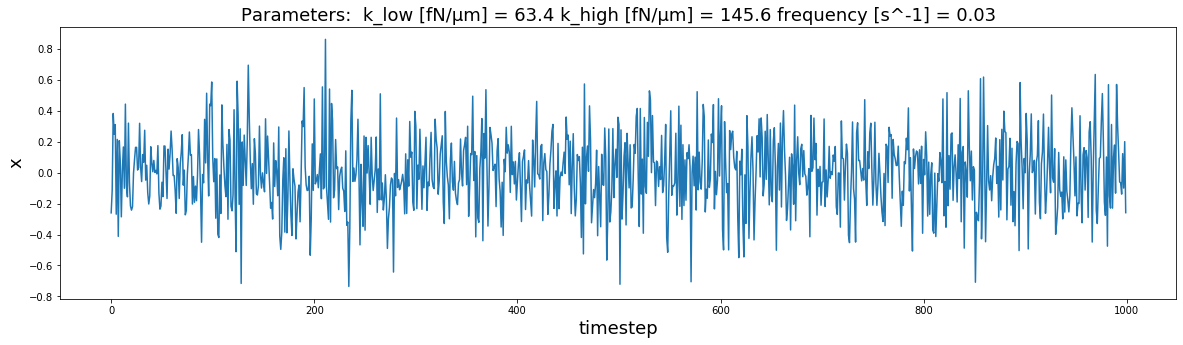

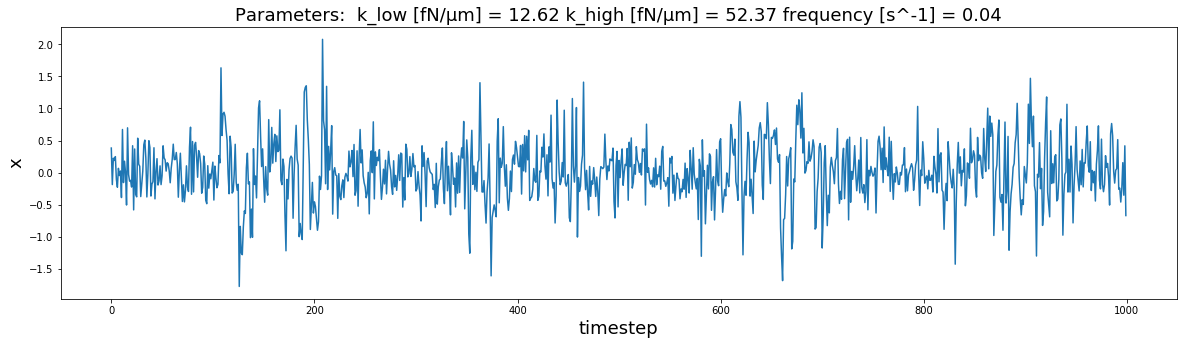

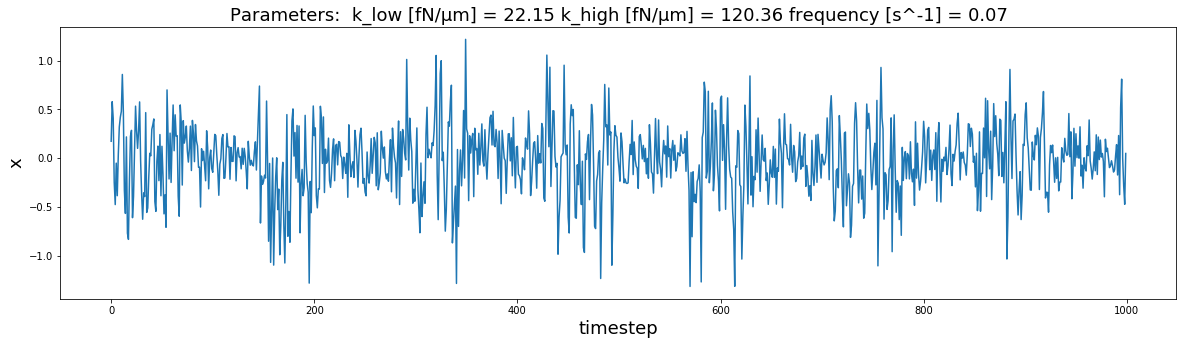

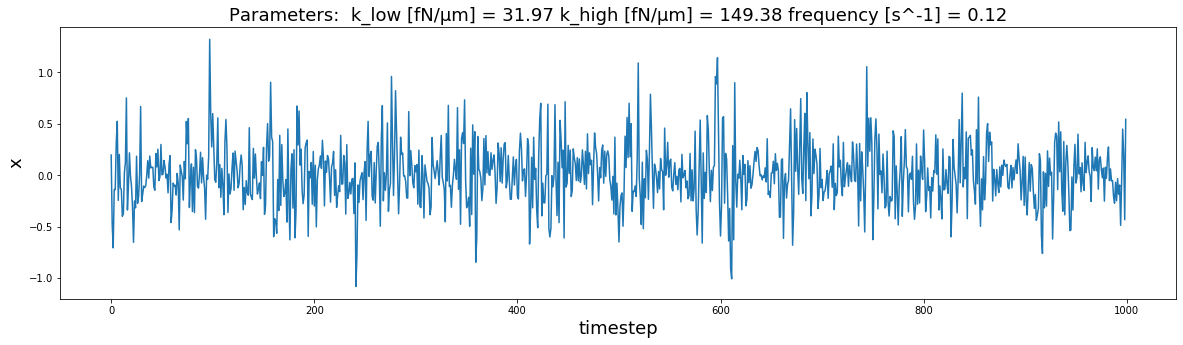

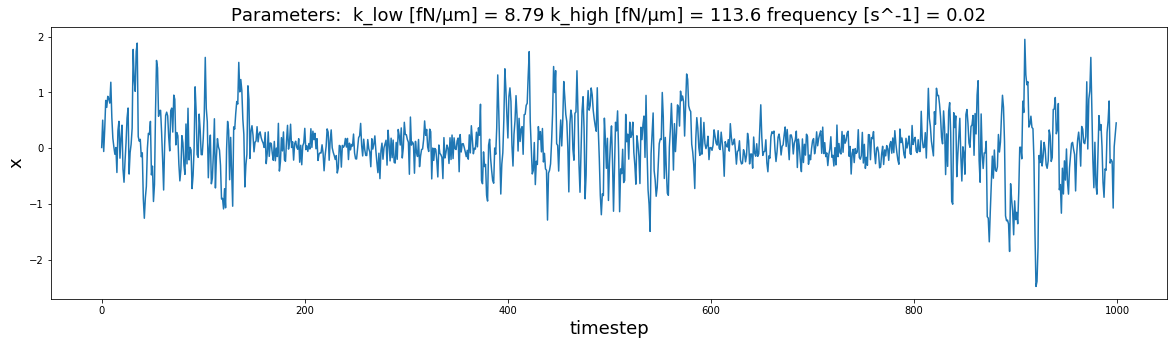

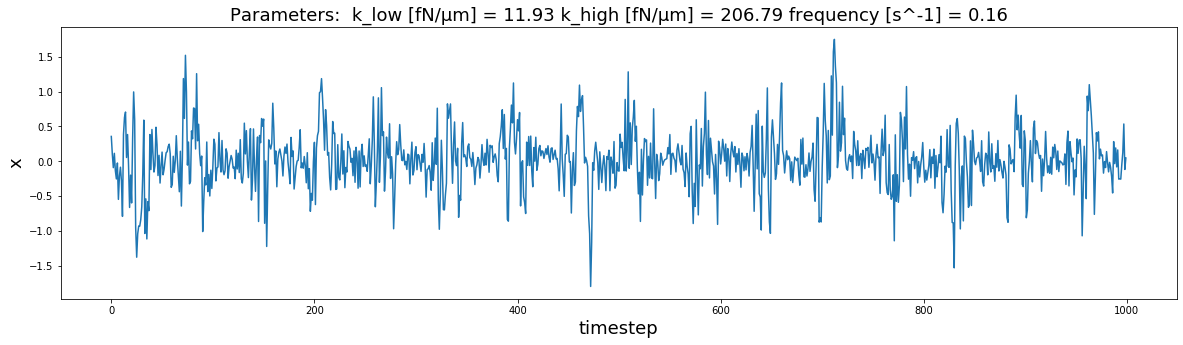

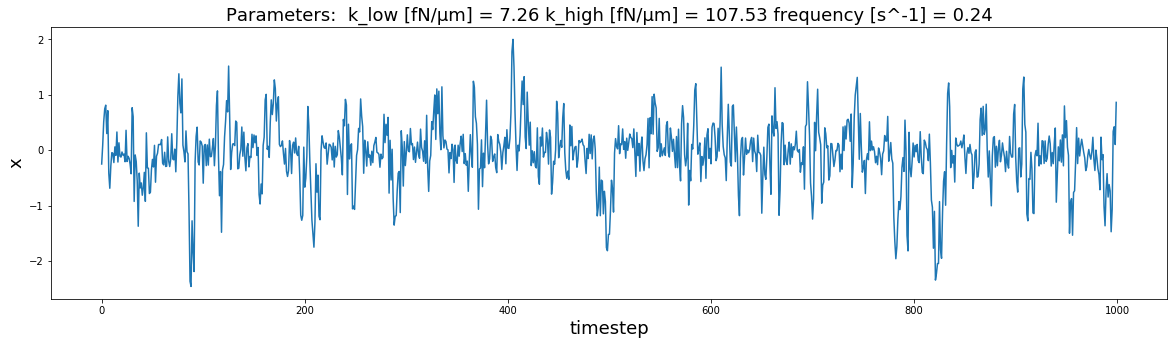

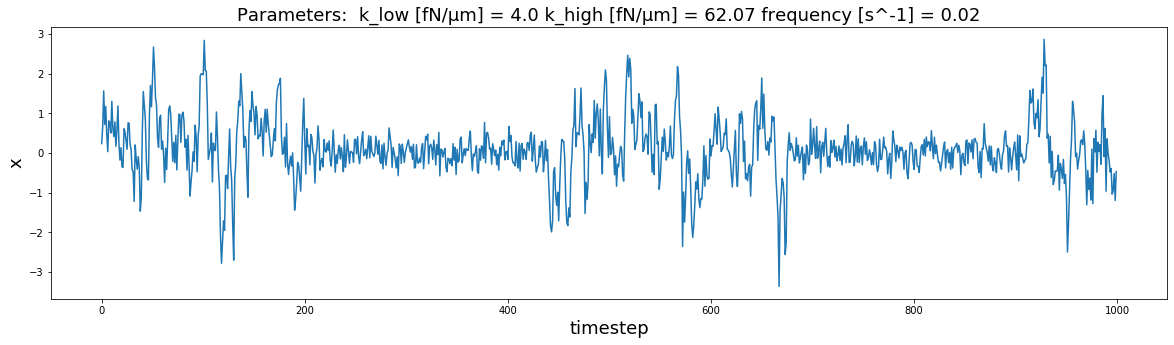

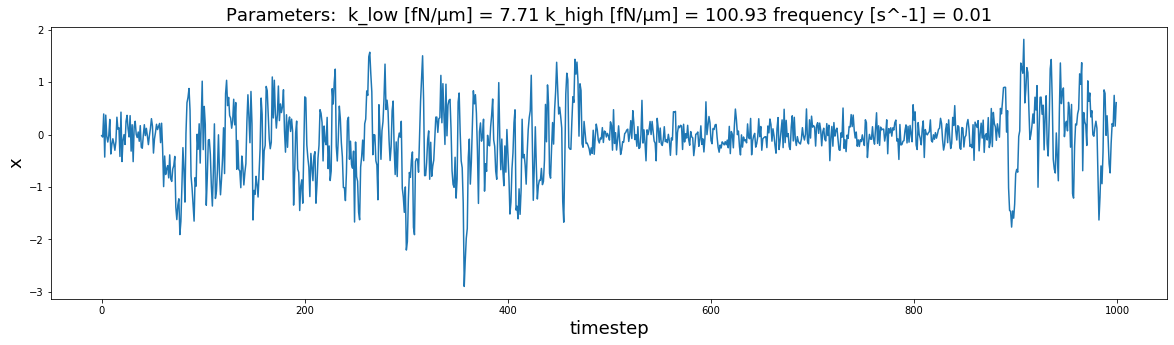

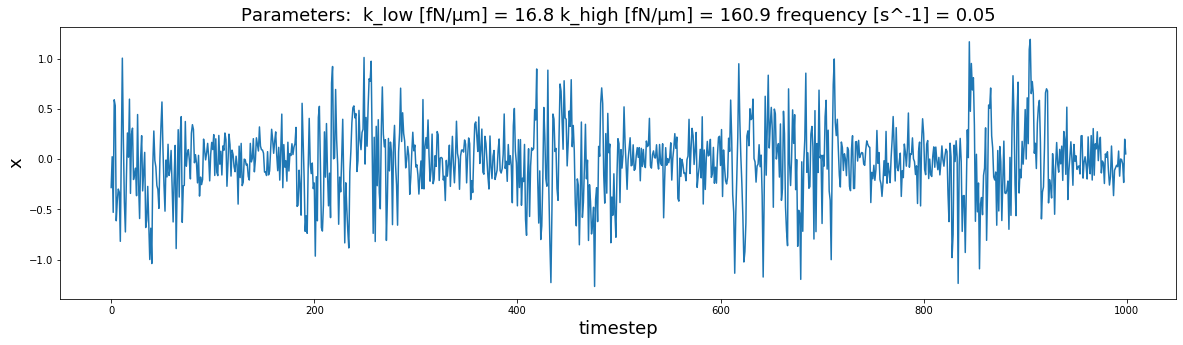

In [14]:
### Show some examples of simulated trajectories

number_of_trajectories_to_show = 10
DeepCalib.plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show)

## 4. CREATE AND COMPILE DEEP LEARNING NETWORK

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.  

Comments:
1. The parameter <strong>input_shape</strong> determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 20 x 50 = 1000.
2. The parmameter <strong>conv_layers_dimensions</strong> determines the number and size of LSTM layers.
3. The parameter <strong>number_of_outputs</strong> determines the number of outputs, i.e. the number of force field parameters to be estimated.

In [4]:
### Define parameters of the deep learning network
input_shape = (None, 50)      
lstm_layers_dimensions = (1000, 250, 50)
number_of_outputs = 3

### Create deep learning network
network = DeepCalib.create_deep_learning_network(input_shape, lstm_layers_dimensions, number_of_outputs)

### Print deep learning network summary
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 1000)        4204000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 250)         1251000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                60200     
_________________________________________________________________
output (Dense)               (None, 3)                 153       
Total params: 5,515,353
Trainable params: 5,515,353
Non-trainable params: 0
_________________________________________________________________


## 5. TRAIN DEEP LEARNING NETWORK

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:
1. The parameter <strong>sample_sizes</strong> determines the sizes of the batches of trajectories used in the training.
2. The parameter <strong>iteration_numbers</strong> determines the numbers of batches used in the training.
3. The parameter <strong>verbose</strong> determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [16]:
### Define parameters of the training

sample_sizes = (32, 128, 512, 2048)
iteration_numbers = (1001, 3001, 3001, 4001)
verbose = .1

### Training
training_history = DeepCalib.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers, verbose)

Sample size     32   iteration number      1   MSE     0.3021   MAE     0.4858   Time 5251.816034 ms
Sample size     32   iteration number     11   MSE     0.1370   MAE     0.3171   Time 260.190010 ms
Sample size     32   iteration number     21   MSE     0.1334   MAE     0.3009   Time 280.639172 ms
Sample size     32   iteration number     31   MSE     0.0955   MAE     0.2451   Time 293.105841 ms
Sample size     32   iteration number     41   MSE     0.1046   MAE     0.2450   Time 274.853706 ms
Sample size     32   iteration number     51   MSE     0.0882   MAE     0.2331   Time 267.853975 ms
Sample size     32   iteration number     61   MSE     0.0911   MAE     0.2285   Time 267.162085 ms
Sample size     32   iteration number     71   MSE     0.1119   MAE     0.2616   Time 251.289368 ms
Sample size     32   iteration number     81   MSE     0.0865   MAE     0.2372   Time 266.506910 ms
Sample size     32   iteration number     91   MSE     0.1123   MAE     0.2487   Time 271.349430 ms

Sample size     32   iteration number    821   MSE     0.0584   MAE     0.1708   Time 272.141933 ms
Sample size     32   iteration number    831   MSE     0.0807   MAE     0.1890   Time 267.195702 ms
Sample size     32   iteration number    841   MSE     0.0400   MAE     0.1511   Time 276.364565 ms
Sample size     32   iteration number    851   MSE     0.0577   MAE     0.1618   Time 285.807371 ms
Sample size     32   iteration number    861   MSE     0.0228   MAE     0.1121   Time 287.341595 ms
Sample size     32   iteration number    871   MSE     0.0281   MAE     0.1174   Time 269.327879 ms
Sample size     32   iteration number    881   MSE     0.0461   MAE     0.1496   Time 279.039621 ms
Sample size     32   iteration number    891   MSE     0.0301   MAE     0.1209   Time 252.919912 ms
Sample size     32   iteration number    901   MSE     0.0445   MAE     0.1443   Time 266.579151 ms
Sample size     32   iteration number    911   MSE     0.0470   MAE     0.1418   Time 249.918938 ms


Sample size    128   iteration number    631   MSE     0.0146   MAE     0.0762   Time 373.704910 ms
Sample size    128   iteration number    641   MSE     0.0107   MAE     0.0707   Time 398.382425 ms
Sample size    128   iteration number    651   MSE     0.0135   MAE     0.0760   Time 381.028652 ms
Sample size    128   iteration number    661   MSE     0.0158   MAE     0.0856   Time 386.934042 ms
Sample size    128   iteration number    671   MSE     0.0157   MAE     0.0776   Time 388.925552 ms
Sample size    128   iteration number    681   MSE     0.0152   MAE     0.0788   Time 379.004717 ms
Sample size    128   iteration number    691   MSE     0.0191   MAE     0.0819   Time 386.602163 ms
Sample size    128   iteration number    701   MSE     0.0166   MAE     0.0799   Time 395.927191 ms
Sample size    128   iteration number    711   MSE     0.0121   MAE     0.0722   Time 475.777149 ms
Sample size    128   iteration number    721   MSE     0.0104   MAE     0.0693   Time 468.746662 ms


Sample size    128   iteration number   1451   MSE     0.0126   MAE     0.0620   Time 408.355474 ms
Sample size    128   iteration number   1461   MSE     0.0076   MAE     0.0565   Time 409.219027 ms
Sample size    128   iteration number   1471   MSE     0.0066   MAE     0.0545   Time 405.831575 ms
Sample size    128   iteration number   1481   MSE     0.0069   MAE     0.0520   Time 400.529146 ms
Sample size    128   iteration number   1491   MSE     0.0097   MAE     0.0640   Time 409.005165 ms
Sample size    128   iteration number   1501   MSE     0.0099   MAE     0.0674   Time 392.035961 ms
Sample size    128   iteration number   1511   MSE     0.0115   MAE     0.0646   Time 381.872892 ms
Sample size    128   iteration number   1521   MSE     0.0068   MAE     0.0523   Time 395.141125 ms
Sample size    128   iteration number   1531   MSE     0.0090   MAE     0.0644   Time 382.893801 ms
Sample size    128   iteration number   1541   MSE     0.0074   MAE     0.0619   Time 397.312641 ms


Sample size    128   iteration number   2271   MSE     0.0065   MAE     0.0547   Time 418.620825 ms
Sample size    128   iteration number   2281   MSE     0.0063   MAE     0.0534   Time 413.417101 ms
Sample size    128   iteration number   2291   MSE     0.0071   MAE     0.0512   Time 415.072680 ms
Sample size    128   iteration number   2301   MSE     0.0053   MAE     0.0513   Time 420.398235 ms
Sample size    128   iteration number   2311   MSE     0.0073   MAE     0.0538   Time 397.290945 ms
Sample size    128   iteration number   2321   MSE     0.0065   MAE     0.0566   Time 383.493662 ms
Sample size    128   iteration number   2331   MSE     0.0063   MAE     0.0502   Time 383.725405 ms
Sample size    128   iteration number   2341   MSE     0.0077   MAE     0.0515   Time 361.455917 ms
Sample size    128   iteration number   2351   MSE     0.0043   MAE     0.0470   Time 383.630037 ms
Sample size    128   iteration number   2361   MSE     0.0064   MAE     0.0534   Time 375.365973 ms


Sample size    512   iteration number     81   MSE     0.0034   MAE     0.0394   Time 869.702339 ms
Sample size    512   iteration number     91   MSE     0.0050   MAE     0.0420   Time 860.729933 ms
Sample size    512   iteration number    101   MSE     0.0035   MAE     0.0404   Time 849.692583 ms
Sample size    512   iteration number    111   MSE     0.0034   MAE     0.0389   Time 857.687235 ms
Sample size    512   iteration number    121   MSE     0.0038   MAE     0.0397   Time 857.757807 ms
Sample size    512   iteration number    131   MSE     0.0037   MAE     0.0411   Time 921.046495 ms
Sample size    512   iteration number    141   MSE     0.0044   MAE     0.0407   Time 897.227764 ms
Sample size    512   iteration number    151   MSE     0.0033   MAE     0.0401   Time 864.052534 ms
Sample size    512   iteration number    161   MSE     0.0037   MAE     0.0408   Time 888.230085 ms
Sample size    512   iteration number    171   MSE     0.0034   MAE     0.0397   Time 900.516033 ms


Sample size    512   iteration number    901   MSE     0.0045   MAE     0.0379   Time 880.984068 ms
Sample size    512   iteration number    911   MSE     0.0040   MAE     0.0378   Time 872.963428 ms
Sample size    512   iteration number    921   MSE     0.0029   MAE     0.0372   Time 874.910116 ms
Sample size    512   iteration number    931   MSE     0.0043   MAE     0.0382   Time 871.454000 ms
Sample size    512   iteration number    941   MSE     0.0031   MAE     0.0384   Time 882.197618 ms
Sample size    512   iteration number    951   MSE     0.0027   MAE     0.0364   Time 871.436834 ms
Sample size    512   iteration number    961   MSE     0.0030   MAE     0.0376   Time 861.974955 ms
Sample size    512   iteration number    971   MSE     0.0035   MAE     0.0374   Time 869.029045 ms
Sample size    512   iteration number    981   MSE     0.0028   MAE     0.0370   Time 872.114420 ms
Sample size    512   iteration number    991   MSE     0.0028   MAE     0.0364   Time 866.348505 ms


Sample size    512   iteration number   1721   MSE     0.0042   MAE     0.0372   Time 846.010685 ms
Sample size    512   iteration number   1731   MSE     0.0026   MAE     0.0345   Time 937.493324 ms
Sample size    512   iteration number   1741   MSE     0.0024   MAE     0.0341   Time 846.644640 ms
Sample size    512   iteration number   1751   MSE     0.0037   MAE     0.0369   Time 841.775417 ms
Sample size    512   iteration number   1761   MSE     0.0030   MAE     0.0344   Time 848.133802 ms
Sample size    512   iteration number   1771   MSE     0.0040   MAE     0.0365   Time 835.517168 ms
Sample size    512   iteration number   1781   MSE     0.0031   MAE     0.0351   Time 845.831394 ms
Sample size    512   iteration number   1791   MSE     0.0028   MAE     0.0360   Time 856.415510 ms
Sample size    512   iteration number   1801   MSE     0.0037   MAE     0.0393   Time 839.811802 ms
Sample size    512   iteration number   1811   MSE     0.0028   MAE     0.0366   Time 841.752052 ms


Sample size    512   iteration number   2541   MSE     0.0022   MAE     0.0329   Time 828.916073 ms
Sample size    512   iteration number   2551   MSE     0.0028   MAE     0.0345   Time 830.255508 ms
Sample size    512   iteration number   2561   MSE     0.0021   MAE     0.0312   Time 852.115154 ms
Sample size    512   iteration number   2571   MSE     0.0030   MAE     0.0342   Time 854.121208 ms
Sample size    512   iteration number   2581   MSE     0.0029   MAE     0.0335   Time 837.109566 ms
Sample size    512   iteration number   2591   MSE     0.0026   MAE     0.0347   Time 835.797071 ms
Sample size    512   iteration number   2601   MSE     0.0027   MAE     0.0351   Time 841.176748 ms
Sample size    512   iteration number   2611   MSE     0.0040   MAE     0.0344   Time 853.959322 ms
Sample size    512   iteration number   2621   MSE     0.0026   MAE     0.0326   Time 844.741583 ms
Sample size    512   iteration number   2631   MSE     0.0025   MAE     0.0331   Time 845.708132 ms


Sample size   2048   iteration number    351   MSE     0.0022   MAE     0.0302   Time 2573.247433 ms
Sample size   2048   iteration number    361   MSE     0.0020   MAE     0.0300   Time 2568.641901 ms
Sample size   2048   iteration number    371   MSE     0.0020   MAE     0.0296   Time 2570.208073 ms
Sample size   2048   iteration number    381   MSE     0.0019   MAE     0.0298   Time 2591.697216 ms
Sample size   2048   iteration number    391   MSE     0.0020   MAE     0.0300   Time 2574.454546 ms
Sample size   2048   iteration number    401   MSE     0.0020   MAE     0.0297   Time 2593.863964 ms
Sample size   2048   iteration number    411   MSE     0.0022   MAE     0.0304   Time 2590.420008 ms
Sample size   2048   iteration number    421   MSE     0.0019   MAE     0.0298   Time 2573.312283 ms
Sample size   2048   iteration number    431   MSE     0.0022   MAE     0.0308   Time 2594.593763 ms
Sample size   2048   iteration number    441   MSE     0.0019   MAE     0.0297   Time 2574.

Sample size   2048   iteration number   1171   MSE     0.0018   MAE     0.0289   Time 2583.492994 ms
Sample size   2048   iteration number   1181   MSE     0.0018   MAE     0.0291   Time 2568.390131 ms
Sample size   2048   iteration number   1191   MSE     0.0020   MAE     0.0297   Time 2564.618587 ms
Sample size   2048   iteration number   1201   MSE     0.0021   MAE     0.0288   Time 2567.378283 ms
Sample size   2048   iteration number   1211   MSE     0.0018   MAE     0.0287   Time 2605.481386 ms
Sample size   2048   iteration number   1221   MSE     0.0018   MAE     0.0285   Time 2580.101013 ms
Sample size   2048   iteration number   1231   MSE     0.0018   MAE     0.0286   Time 2598.979235 ms
Sample size   2048   iteration number   1241   MSE     0.0020   MAE     0.0291   Time 2573.666573 ms
Sample size   2048   iteration number   1251   MSE     0.0018   MAE     0.0288   Time 2582.264185 ms
Sample size   2048   iteration number   1261   MSE     0.0020   MAE     0.0288   Time 2571.

Sample size   2048   iteration number   1991   MSE     0.0020   MAE     0.0290   Time 2560.373068 ms
Sample size   2048   iteration number   2001   MSE     0.0019   MAE     0.0283   Time 2591.019869 ms
Sample size   2048   iteration number   2011   MSE     0.0017   MAE     0.0285   Time 2583.243370 ms
Sample size   2048   iteration number   2021   MSE     0.0018   MAE     0.0281   Time 2569.117308 ms
Sample size   2048   iteration number   2031   MSE     0.0018   MAE     0.0288   Time 2570.128202 ms
Sample size   2048   iteration number   2041   MSE     0.0021   MAE     0.0300   Time 2596.108675 ms
Sample size   2048   iteration number   2051   MSE     0.0019   MAE     0.0293   Time 2568.464041 ms
Sample size   2048   iteration number   2061   MSE     0.0018   MAE     0.0288   Time 2559.996605 ms
Sample size   2048   iteration number   2071   MSE     0.0018   MAE     0.0284   Time 2564.882278 ms
Sample size   2048   iteration number   2081   MSE     0.0018   MAE     0.0278   Time 2573.

Sample size   2048   iteration number   2811   MSE     0.0016   MAE     0.0268   Time 2580.345392 ms
Sample size   2048   iteration number   2821   MSE     0.0017   MAE     0.0272   Time 2567.068100 ms
Sample size   2048   iteration number   2831   MSE     0.0016   MAE     0.0269   Time 2573.043346 ms
Sample size   2048   iteration number   2841   MSE     0.0016   MAE     0.0271   Time 2576.556921 ms
Sample size   2048   iteration number   2851   MSE     0.0018   MAE     0.0274   Time 2579.491854 ms
Sample size   2048   iteration number   2861   MSE     0.0016   MAE     0.0274   Time 2585.993052 ms
Sample size   2048   iteration number   2871   MSE     0.0019   MAE     0.0281   Time 2569.130421 ms
Sample size   2048   iteration number   2881   MSE     0.0015   MAE     0.0271   Time 2571.813107 ms
Sample size   2048   iteration number   2891   MSE     0.0018   MAE     0.0275   Time 2567.286730 ms
Sample size   2048   iteration number   2901   MSE     0.0018   MAE     0.0284   Time 2563.

Sample size   2048   iteration number   3631   MSE     0.0016   MAE     0.0271   Time 2587.877512 ms
Sample size   2048   iteration number   3641   MSE     0.0016   MAE     0.0271   Time 2582.113743 ms
Sample size   2048   iteration number   3651   MSE     0.0016   MAE     0.0275   Time 2580.678701 ms
Sample size   2048   iteration number   3661   MSE     0.0016   MAE     0.0274   Time 2558.517933 ms
Sample size   2048   iteration number   3671   MSE     0.0018   MAE     0.0277   Time 2581.882238 ms
Sample size   2048   iteration number   3681   MSE     0.0017   MAE     0.0273   Time 2567.159653 ms
Sample size   2048   iteration number   3691   MSE     0.0017   MAE     0.0274   Time 2554.721594 ms
Sample size   2048   iteration number   3701   MSE     0.0019   MAE     0.0284   Time 2578.359842 ms
Sample size   2048   iteration number   3711   MSE     0.0016   MAE     0.0267   Time 2575.479269 ms
Sample size   2048   iteration number   3721   MSE     0.0016   MAE     0.0268   Time 2580.

## 6. PLOT LEARNING PERFORMANCE

The learning performance is plotted. The MSE, MAE, sample size, iteration number and iteration time are plotted against the number of timesteps. 

Comment:
1. The parameter <strong>number_of_timesteps_for_average</strong> determines the length of the average. It must be a positive integer number.

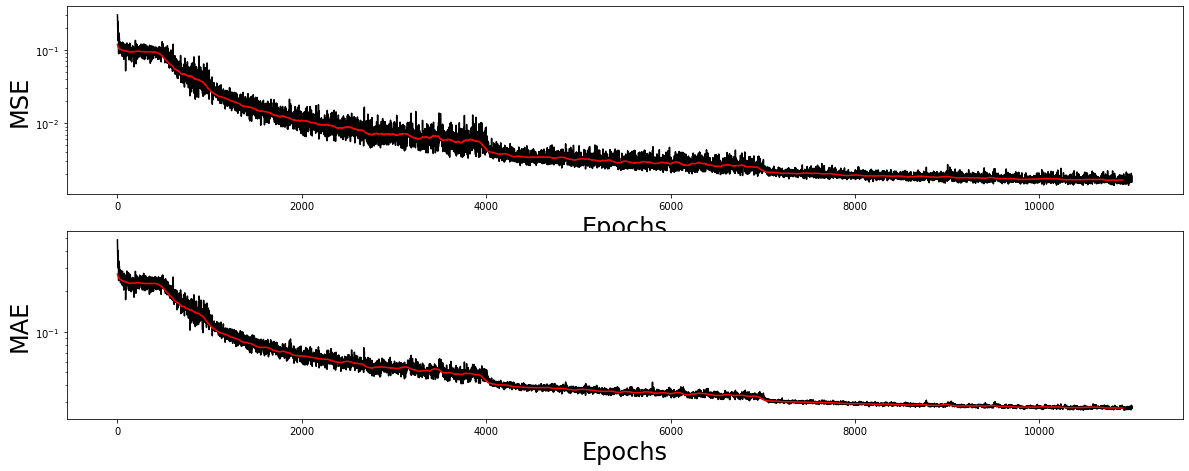

In [17]:
### Plot learning performance
number_of_timesteps_for_average = 100

DeepCalib.plot_learning_performance(training_history, number_of_timesteps_for_average)

## 7. TEST DEEP LEARNING NETWORK ON NEW SIMULATED TRAJECTORIES

The deep learning network is tested on new simulated trajectories (parameters are defined in [section 2](#sec2)). The predicted values of the targets are plotted as function of their ground-truth values both in scaled and physical units.

Comments:
1. The parameter <strong>number_of_predictions_to_show</strong> determines the number of predictions that are shown.

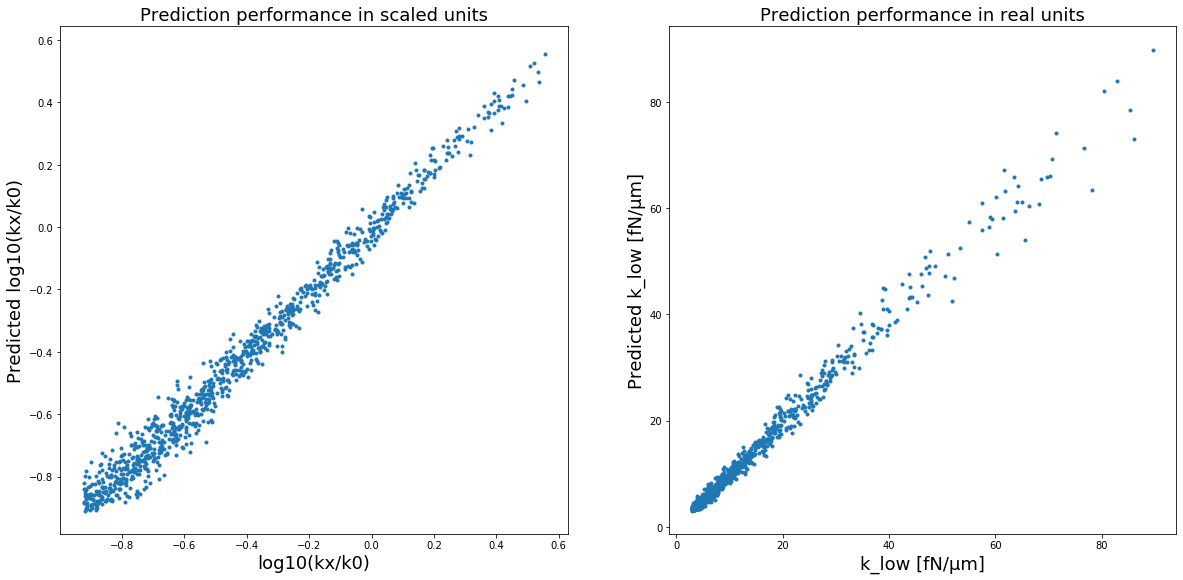

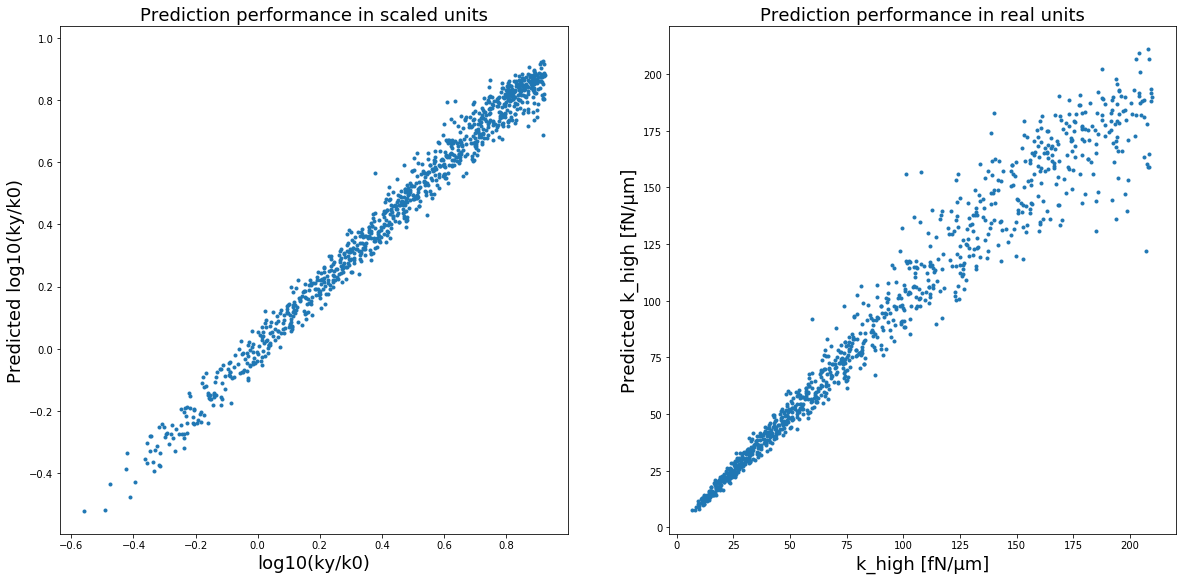

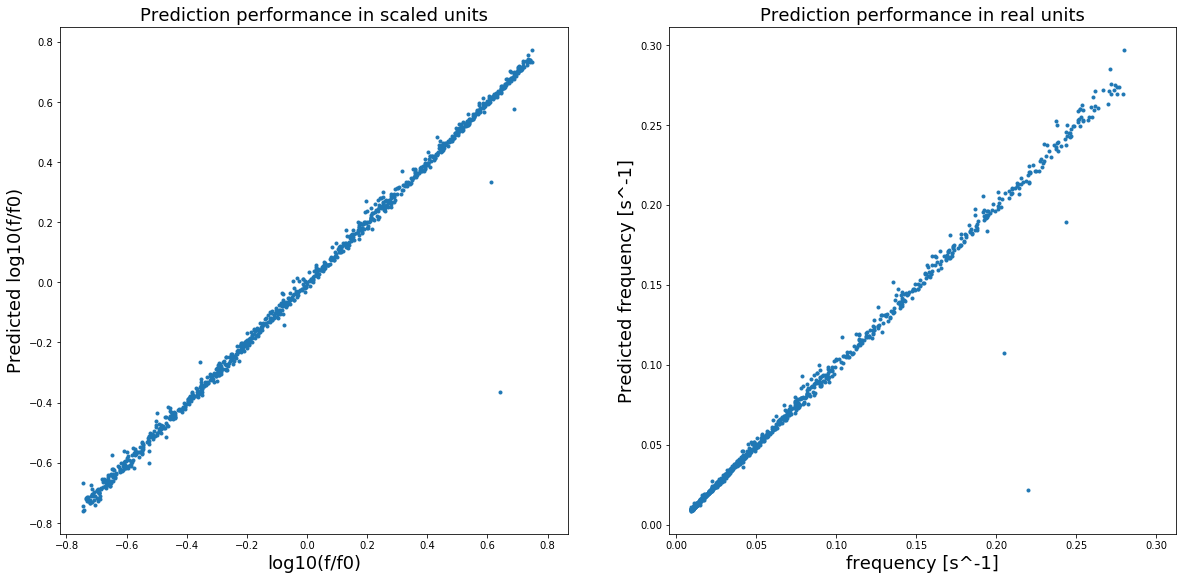

In [18]:
### Test the predictions of the deep learning network on some generated trajectories

number_of_predictions_to_show = 1000

%matplotlib inline
DeepCalib.plot_test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

## 8. SAVE DEEP LEARNING NETWORK

Comments:
1. The parameter <strong>save_file_name</strong> is the name of the file where the deep learnign network is saved.
2. By default, the network is saved in the same folder where DeepCalib is running.

In [20]:
save_file_name = 'Network_Example_4a.h5'
network.save(save_file_name)